In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)
num_classes = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteB9KX0A/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteB9KX0A/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


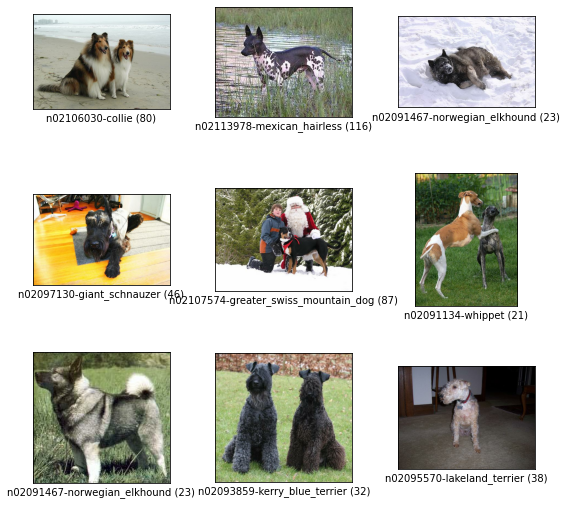

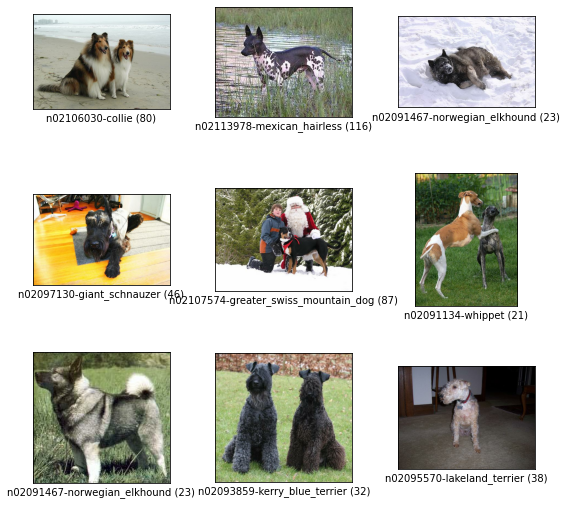

In [3]:
tfds.show_examples(ds_info, ds_test)

In [4]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [6]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [7]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug: # basic augmentation
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # cutmix
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

In [15]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [16]:
tf.random.set_seed(2020)

In [17]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94765736/94765736 [==============================] - 1s 0us/step


In [18]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [19]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 57s 55ms/step - loss: 4.4893 - accuracy: 0.0743 - val_loss: 4.7106 - val_accuracy: 0.0559
Epoch 2/20
750/750 [==============================] - 40s 54ms/step - loss: 2.9434 - accuracy: 0.3710 - val_loss: 2.1584 - val_accuracy: 0.4893
Epoch 3/20
750/750 [==============================] - 40s 54ms/step - loss: 1.9774 - accuracy: 0.5677 - val_loss: 1.5939 - val_accuracy: 0.5925
Epoch 4/20
750/750 [==============================] - 40s 54ms/step - loss: 1.4815 - accuracy: 0.6672 - val_loss: 1.3355 - val_accuracy: 0.6454
Epoch 5/20
750/750 [==============================] - 40s 53ms/step - loss: 1.1882 - accuracy: 0.7277 - val_loss: 1.1906 - val_accuracy: 0.6684
Epoch 6/20
750/750 [==============================] - 40s 53ms/step - loss: 0.9712 - accuracy: 0.7883 - val_loss: 1.1057 - val_accuracy: 0.6887
Epoch 7/20
750/750 [==============================] - 40s 53ms/step - loss: 0.7828 - accuracy: 0.8341 - val_loss: 1.0554 - val_accuracy:

In [20]:
basic_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
basic_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'],
)

In [22]:
history_basic_aug_resnet50 = basic_aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
     epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 46s 54ms/step - loss: 4.3789 - accuracy: 0.0889 - val_loss: 4.3819 - val_accuracy: 0.0789
Epoch 2/20
750/750 [==============================] - 40s 54ms/step - loss: 2.8979 - accuracy: 0.3720 - val_loss: 2.0505 - val_accuracy: 0.5036
Epoch 3/20
750/750 [==============================] - 41s 54ms/step - loss: 2.0038 - accuracy: 0.5468 - val_loss: 1.5811 - val_accuracy: 0.5956
Epoch 4/20
750/750 [==============================] - 41s 54ms/step - loss: 1.5567 - accuracy: 0.6347 - val_loss: 1.3272 - val_accuracy: 0.6458
Epoch 5/20
750/750 [==============================] - 41s 55ms/step - loss: 1.2848 - accuracy: 0.6901 - val_loss: 1.1913 - val_accuracy: 0.6711
Epoch 6/20
750/750 [==============================] - 41s 55ms/step - loss: 1.0846 - accuracy: 0.7347 - val_loss: 1.0971 - val_accuracy: 0.6869
Epoch 7/20
750/750 [==============================] - 41s 55ms/step - loss: 0.9341 - accuracy: 0.7713 - val_loss: 1.0311 - val_accuracy:

In [23]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'],
)

In [25]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
     epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 48s 55ms/step - loss: 4.8853 - accuracy: 0.0202 - val_loss: 5.1048 - val_accuracy: 0.0215
Epoch 2/20
750/750 [==============================] - 40s 54ms/step - loss: 4.3955 - accuracy: 0.0959 - val_loss: 3.2992 - val_accuracy: 0.2664
Epoch 3/20
750/750 [==============================] - 40s 54ms/step - loss: 3.9205 - accuracy: 0.2069 - val_loss: 2.4908 - val_accuracy: 0.4138
Epoch 4/20
750/750 [==============================] - 41s 55ms/step - loss: 3.5912 - accuracy: 0.2928 - val_loss: 1.9797 - val_accuracy: 0.5161
Epoch 5/20
750/750 [==============================] - 41s 55ms/step - loss: 3.3556 - accuracy: 0.3503 - val_loss: 1.6996 - val_accuracy: 0.5687
Epoch 6/20
750/750 [==============================] - 41s 55ms/step - loss: 3.2148 - accuracy: 0.3853 - val_loss: 1.4985 - val_accuracy: 0.6065
Epoch 7/20
750/750 [==============================] - 41s 55ms/step - loss: 3.0682 - accuracy: 0.4252 - val_loss: 1.3859 - val_accuracy:

In [26]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [28]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
     epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 48s 56ms/step - loss: 3.7513 - accuracy: 0.2355 - val_loss: 4.2708 - val_accuracy: 0.0958
Epoch 2/20
750/750 [==============================] - 41s 54ms/step - loss: 2.8978 - accuracy: 0.4718 - val_loss: 1.6046 - val_accuracy: 0.5595
Epoch 3/20
750/750 [==============================] - 40s 54ms/step - loss: 2.6101 - accuracy: 0.5736 - val_loss: 1.3361 - val_accuracy: 0.6306
Epoch 4/20
750/750 [==============================] - 41s 54ms/step - loss: 2.4243 - accuracy: 0.6428 - val_loss: 1.3696 - val_accuracy: 0.6257
Epoch 5/20
750/750 [==============================] - 41s 55ms/step - loss: 2.3264 - accuracy: 0.6827 - val_loss: 1.5593 - val_accuracy: 0.5939
Epoch 6/20
750/750 [==============================] - 42s 56ms/step - loss: 2.1909 - accuracy: 0.7319 - val_loss: 1.3134 - val_accuracy: 0.6368
Epoch 7/20
750/750 [==============================] - 42s 56ms/step - loss: 2.1090 - accuracy: 0.7542 - val_loss: 1.2315 - val_accuracy:

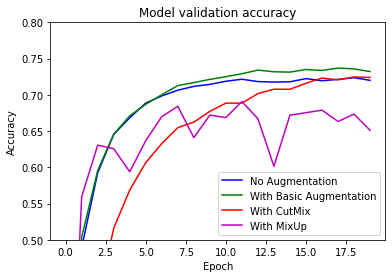

In [29]:
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.ylim(0.5, 0.8)
plt.show()

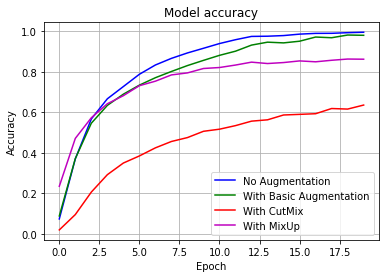

In [33]:
plt.plot(history_resnet50.history['accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['accuracy'], 'm')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.grid(True)
plt.show()

MixUp이 결국 수렴하지 못한 채로 끝났다.